# Task 2: Hyperelasticity



In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib


### Data import

In [2]:
import numpy as np
data_uniaxial = np.loadtxt('../../BCC/BCC_uniaxial.txt')
data_shear = np.loadtxt('../../BCC/BCC_shear.txt')

data_test1 = np.loadtxt('../../BCC/BCC_test1.txt')
data_test2 = np.loadtxt('../../BCC/BCC_test2.txt')
data_test3 = np.loadtxt('../../BCC/BCC_test3.txt')

def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    SE = data[:, 18] 
    return F, P, SE


F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)
F_shear, P_shear, W_shear = process_data(data_shear)

F_test3, P_test3, W_test3 = process_data(data_test3)

In [3]:
def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    batch_size = tf.shape(F)[0]
    
    # 计算右 Cauchy-Green 张量 C
    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = tf.linalg.trace(C)  # I1: Tr(C)
    Cof_C = tf.linalg.inv(C) * tf.linalg.det(C)[:, None, None]  # Cofactor matrix
    I2 = tf.linalg.trace(Cof_C)  # I2: Tr(Cof(C))
    J = tf.linalg.det(F)  # J: det(F)
    
    # 计算 G_cub 和不变量 I7
    e = tf.eye(3, dtype=tf.float32)  # 基础向量
    G_cub = tf.einsum('ij,kl->ijkl', e, e)  # 立方对称张量 G_cub
    G_cub = tf.tile(G_cub[None, :, :, :, :], [batch_size, 1, 1, 1, 1])  # 批量化
    I7 = tf.einsum('bij,bijkl,bkl->b', C, G_cub, C)  # I7: C : G_cub : C
    
    # 计算 I11
    I11 = tf.einsum('bij,bijkl,bkl->b', Cof_C, G_cub, Cof_C)  # I11: Cof(C) : G_cub : Cof(C)
    
    return I1, I2, J, I7, I11


In [4]:
I1_data_uniaxial,I2_data_uniaxial,J_data_uniaxial,I7_data_uniaxial,I11_data_uniaxial = compute_invariants(F_uniaxial)
I1_data_shear,I2_data_shear,J_data_shear,I7_data_shear,I11_data_shear = compute_invariants(F_shear)


In [5]:
I_train_uniaxial = np.column_stack((I1_data_uniaxial,I2_data_uniaxial, J_data_uniaxial, -J_data_uniaxial, I7_data_uniaxial, I11_data_uniaxial))
I_train_shear = np.column_stack((I1_data_shear,I2_data_shear, J_data_shear, -J_data_shear, I7_data_shear, I11_data_shear))


In [18]:
F_train = np.concatenate([F_uniaxial, F_shear], axis=0)
P_train = np.concatenate([P_uniaxial, P_shear], axis=0)
I_train = np.concatenate([I_train_uniaxial, I_train_shear], axis=0)
W_train = np.concatenate([W_uniaxial, W_shear], axis=0)


In [7]:
F_train_tensor = tf.convert_to_tensor(F_train.reshape(-1,9), dtype=tf.float32)

In [8]:
def scale_data(P_train, W_train):
    # Step 1: 计算缩放因子 a
    # 这里使用 P_train 中所有分量的最大绝对值的倒数
    max_abs_P = np.max(np.abs(P_train))
    a = 1.0 / max_abs_P

    # Step 2: 应用缩放因子到应力张量和应变能
    P_train_scaled = a * P_train
    W_train_scaled = a * W_train

    return P_train_scaled, W_train_scaled, a

P_train_scaled, W_train_scaled, a = scale_data(P_train, W_train)
P_train_scaled = P_train_scaled.reshape(-1, 9)

In [9]:
P_train_tensor = tf.convert_to_tensor(P_train_scaled, dtype=tf.float32)
W_train_tensor = tf.convert_to_tensor(W_train_scaled, dtype=tf.float32)
I_train_tensor = tf.convert_to_tensor(I_train, dtype=tf.float32)

In [10]:

I_test3 = compute_invariants(F_test3)
I_test3_tensor = tf.convert_to_tensor(I_test3, dtype=tf.float32)

F_test3_tensor = tf.convert_to_tensor(F_test3.reshape(-1,9), dtype=tf.float32)
P_test3_scaled = a * P_test3

P_test3_tensor = tf.convert_to_tensor(P_test3_scaled.reshape(-1,9), dtype=tf.float32)
W_test3_scaled = a * W_test3

W_test3_tensor = tf.convert_to_tensor(W_test3_scaled, dtype=tf.float32)


### Load ICNN model

In [12]:
import models_icnn as lm2_icnn

import importlib
importlib.reload(lm2_icnn)
model_icnn = lm2_icnn.main()

model_icnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 private_c_to_w_1 (_C_to_W)  (None, 1)                 401       
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
13/13 [==============================] - 0s 2ms/step - loss: 366.1104
Epoch 2/2500
13/13 [==============================] - 0s 1ms/step - loss: 286.8074
Epoch 3/2500
13/13 [==============================] - 0s 1ms/step - loss: 210.4936
Epoch 4/2500
13/13 [==============================] - 0s 1ms/step - loss: 159.2685
Epoch 5/2500
13/13 [==============================] - 0s 1ms/step - loss: 124.3134
Epoch 6/2500
13/13 [==============================] - 0s 1ms/step - loss: 99.8130
Epoch 7/2500
13/13 [==============================] - 0s 1ms/step - loss: 82.0851
Epoch 8/2500
13/13 [==============================] - 0s 1ms/step - loss: 68.7415
Epoch 9/2500
13/13 [==============================] - 0s 1ms/step - loss: 58.7329
Epoch 10/2500
13/13 [==============================] - 0s 1ms/step - loss: 50.7311
Epoch 11/2500
13/13 [==============================] - 0s 1ms/step - loss: 44.2569
Epoch 12/2500
13/13 [==============================] - 0s 1ms/step - loss: 39.0172
Epoch 13

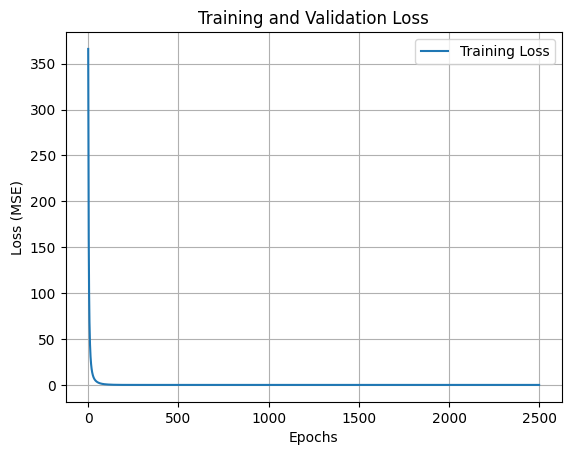

In [10]:

history = model_icnn.fit(I_train_tensor, W_train_tensor, epochs=2500)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


### 5.3 Deformation-gradient based neural network model

In [89]:

import models_dg as lm2_dg

import importlib
importlib.reload(lm2_dg)
models_dg = lm2_dg.main()

models_dg.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 F_input (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 Cof_F_input (InputLayer)       [(None, 9)]          0           []                               
                                                                                                  
 det_F_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 f_to_w_and_p_5 (F_to_W_and_P)  ((None, 1),          609         ['F_input[0][0]',                
                                 (None, 9))                       'Cof_F_input[0][0]',      

In [35]:
Cof_F_train = np.linalg.det(F_train)[:, None, None] * np.linalg.inv(F_train.transpose(0, 2, 1))
Cof_F_train_input = Cof_F_train.reshape(-1,9)
det_F_train_input = np.linalg.det(F_train)
F_train_input = F_train.reshape(-1,9)

In [36]:
F_train_input_tensor = tf.convert_to_tensor(F_train_input, dtype=tf.float32)
Cof_F_train_tensor = tf.convert_to_tensor(Cof_F_train_input, dtype=tf.float32)
det_F_train_tensor = tf.convert_to_tensor(det_F_train_input, dtype=tf.float32)

Epoch 1/2500
9/9 [==============================] - 1s 2ms/step - loss: 23.1855 - f_to_w_and_p_5_loss: 23.1406 - f_to_w_and_p_5_1_loss: 0.0449
Epoch 2/2500
9/9 [==============================] - 0s 2ms/step - loss: 21.8864 - f_to_w_and_p_5_loss: 21.8434 - f_to_w_and_p_5_1_loss: 0.0430
Epoch 3/2500
9/9 [==============================] - 0s 2ms/step - loss: 18.3441 - f_to_w_and_p_5_loss: 18.3023 - f_to_w_and_p_5_1_loss: 0.0417
Epoch 4/2500
9/9 [==============================] - 0s 2ms/step - loss: 15.5422 - f_to_w_and_p_5_loss: 15.5011 - f_to_w_and_p_5_1_loss: 0.0411
Epoch 5/2500
9/9 [==============================] - 0s 1ms/step - loss: 13.3353 - f_to_w_and_p_5_loss: 13.2945 - f_to_w_and_p_5_1_loss: 0.0408
Epoch 6/2500
9/9 [==============================] - 0s 1ms/step - loss: 11.5880 - f_to_w_and_p_5_loss: 11.5475 - f_to_w_and_p_5_1_loss: 0.0406
Epoch 7/2500
9/9 [==============================] - 0s 1ms/step - loss: 10.2241 - f_to_w_and_p_5_loss: 10.1837 - f_to_w_and_p_5_1_loss: 0.0404

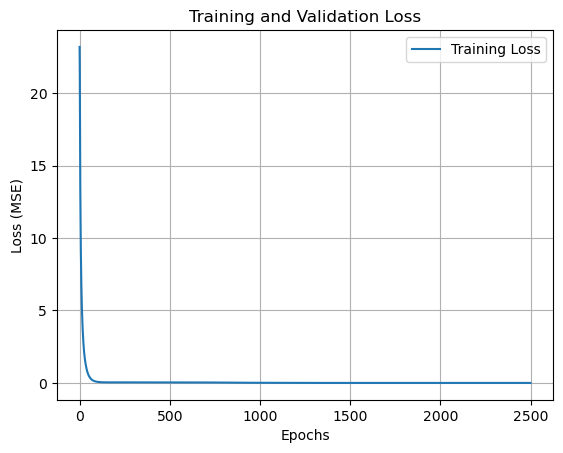

In [90]:
history = models_dg.fit([F_train_input_tensor,Cof_F_train_tensor,det_F_train_tensor], [W_train_tensor,P_train_tensor], epochs=2500)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


### 5.3 Evaluate

In [105]:
import scipy.stats
import numpy as np

# 生成随机旋转矩阵
def random_rotation_matrix():
    # 使用SciPy的旋转矩阵生成器
    Q = scipy.stats.special_ortho_group.rvs(3)
    return Q
def generate_multiple_rotations(num_rotations):
    Q_list = [random_rotation_matrix() for _ in range(num_rotations)]
    Q_array = np.array(Q_list)
    return Q_array
num_rotations = 1
Q_array = generate_multiple_rotations(num_rotations)

In [106]:
def compute_QF(Q_array, F_array):

    QF_array = np.einsum('mij,njk->mnik', Q_array, F_array)
    return QF_array

QF_test3_array = compute_QF(Q_array, F_test3)

In [108]:
QF_test3_array = QF_test3_array.reshape(-1,3,3)

In [109]:
def compute_stress_tensor(F,model):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(F)
        

        I1, I2, J, I7, I11 = compute_invariants(F)
        I_train = tf.stack([I1, I2, J, -J, I7, I11], axis=1)
        W_pred = model(I_train)

  
    P = tape.gradient(W_pred, F)
    
 
    
    return P

In [110]:
I1_test3_QF,I2_test3_QF,J_test3_QF,I7_test3_QF,I11_test3_QF= compute_invariants(QF_test3_array)
I_test3_QF = np.column_stack((I1_test3_QF,I2_test3_QF, J_test3_QF, -J_test3_QF, I7_test3_QF, I11_test3_QF))
W_test3_QF_icnn_pred = model_icnn(I_test3_QF)
P_test3_QF_icnn_pred= compute_stress_tensor(QF_test3_array,model_icnn)

In [111]:
Cof_test3_QF = np.linalg.det(QF_test3_array)[:, None, None] * np.linalg.inv(QF_test3_array.transpose(0, 2, 1))
Cof_test3_QF_input = Cof_test3_QF.reshape(-1,9)
det_test3_QF_input = np.linalg.det(QF_test3_array)
test3_QF_input = QF_test3_array.reshape(-1,9)
test3_QF_input_tensor = tf.convert_to_tensor(test3_QF_input, dtype=tf.float32)
Cof_test3_QF_tensor = tf.convert_to_tensor(Cof_test3_QF_input, dtype=tf.float32)
det_test3_QF_tensor = tf.convert_to_tensor(det_test3_QF_input, dtype=tf.float32)
W_test3_QF_dg_pred,P_test3_QF_dg_pred= models_dg([test3_QF_input_tensor,Cof_test3_QF_tensor,det_test3_QF_tensor])

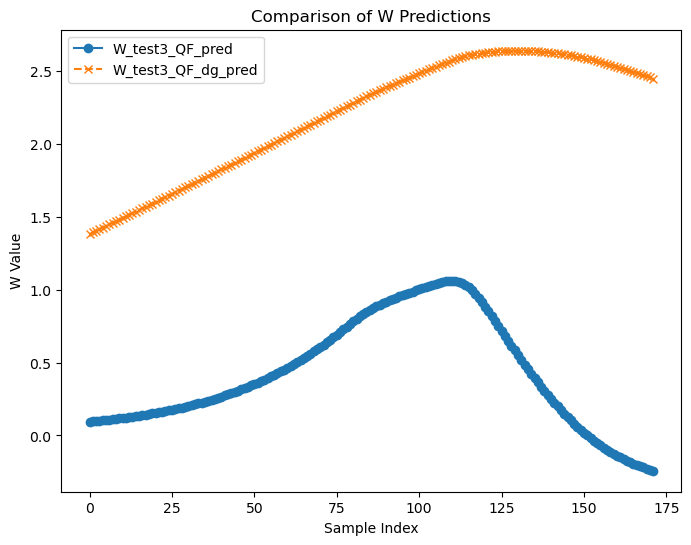

In [112]:
# 创建图形
plt.figure(figsize=(8,6))

# 绘制W_test3_QF_pred曲线
plt.plot(W_test3_QF_icnn_pred, label='W_test3_QF_pred', marker='o', linestyle='-')

# 绘制W_test3_QF_dg_pred曲线
plt.plot(W_test3_QF_dg_pred, label='W_test3_QF_dg_pred', marker='x', linestyle='--')

# 添加图例
plt.legend()

# 添加坐标轴标签和标题
plt.xlabel('Sample Index')
plt.ylabel('W Value')
plt.title('Comparison of W Predictions')

# 显示图形
plt.show()

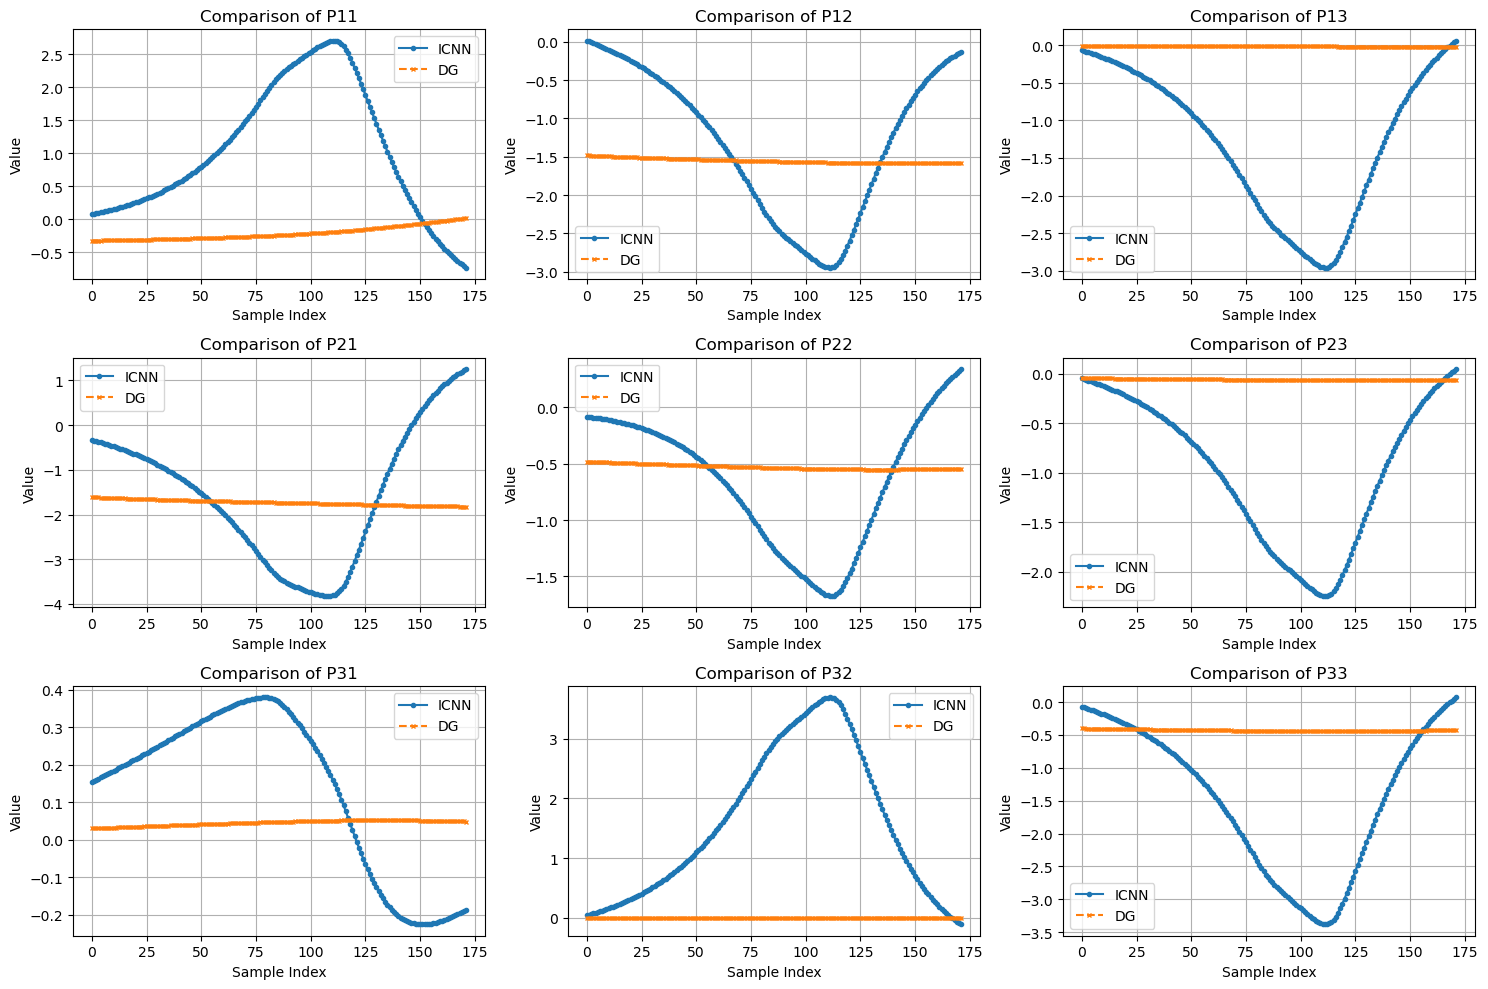

In [113]:
# 设置图表样式和大小
plt.figure(figsize=(15, 10))
components = ['P11', 'P12', 'P13', 'P21', 'P22', 'P23', 'P31', 'P32', 'P33']
P_test3_QF_dg_pred = P_test3_QF_dg_pred.numpy().reshape(-1, 3, 3)
# 遍历每个分量
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i * 3 + j + 1)  # 在 3x3 网格中放置子图
        plt.plot(P_test3_QF_icnn_pred[:, i, j], label='ICNN', linestyle='-', marker='o', markersize=3)
        plt.plot(P_test3_QF_dg_pred[:, i, j], label='DG', linestyle='--', marker='x', markersize=3)
        plt.title(f"Comparison of {components[i * 3 + j]}")
        plt.xlabel("Sample Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()

# 调整布局，展示图表
plt.tight_layout()
plt.show()

### 5.4 Data augmentation

#### 8 observer

In [182]:
Q_8 = generate_multiple_rotations(8)
QF_8 = compute_QF(Q_8, F_train)
Q_16 = generate_multiple_rotations(16)
QF_16 = compute_QF(Q_16, F_train)
Q_32 = generate_multiple_rotations(32)
QF_32 = compute_QF(Q_32, F_train)
Q_64 = generate_multiple_rotations(64)
QF_64 = compute_QF(Q_64, F_train)

In [183]:
QF_8 = QF_8.reshape(-1,3,3)
QF_16 = QF_16.reshape(-1,3,3)
QF_32 = QF_32.reshape(-1,3,3)
QF_64 = QF_64.reshape(-1,3,3)

In [184]:
print(QF_8.shape)
print(QF_16.shape)
print(QF_32.shape)
print(QF_64.shape)

(2208, 3, 3)
(4416, 3, 3)
(8832, 3, 3)
(17664, 3, 3)


In [185]:
Cof_QF_8 = np.linalg.det(QF_8)[:, None, None] * np.linalg.inv(QF_8.transpose(0, 2, 1))
Cof_QF_8_input = Cof_QF_8.reshape(-1,9)
det_QF_8_input = np.linalg.det(QF_8)
QF_8_input = QF_8.reshape(-1,9)
QF_8_input_tensor = tf.convert_to_tensor(QF_8_input, dtype=tf.float32)
Cof_QF_8_tensor = tf.convert_to_tensor(Cof_QF_8_input, dtype=tf.float32)
det_QF_8_tensor = tf.convert_to_tensor(det_QF_8_input, dtype=tf.float32)


In [186]:
print(QF_8_input_tensor.shape)
print(Cof_QF_8_tensor.shape)
print(det_QF_8_tensor.shape)


(2208, 9)
(2208, 9)
(2208,)


In [187]:
W_train_repeated_8 = np.tile(W_train, 8)
P_train_repeated_8 = np.tile(P_train, (8,1,1))
P_train_repeated_8_scaled, W_train_repeated_8_scaled, b = scale_data(P_train_repeated_8, W_train_repeated_8)
W_train_repeated_8_tensor = tf.convert_to_tensor(W_train_repeated_8_scaled, dtype=tf.float32)
P_train_repeated_8_tensor = tf.convert_to_tensor(P_train_repeated_8_scaled.reshape(-1,9), dtype=tf.float32)


In [188]:
models_ob8 = lm2_dg.main()

history = models_ob8.fit([QF_8_input_tensor,Cof_QF_8_tensor,det_QF_8_tensor], [W_train_repeated_8_tensor,P_train_repeated_8_tensor], epochs=2500)

Epoch 1/2500
69/69 [==============================] - 1s 1ms/step - loss: 11.6227 - f_to_w_and_p_13_loss: 11.5833 - f_to_w_and_p_13_1_loss: 0.0394
Epoch 2/2500
69/69 [==============================] - 0s 1ms/step - loss: 4.9391 - f_to_w_and_p_13_loss: 4.9065 - f_to_w_and_p_13_1_loss: 0.0327
Epoch 3/2500
69/69 [==============================] - 0s 1ms/step - loss: 2.6641 - f_to_w_and_p_13_loss: 2.6327 - f_to_w_and_p_13_1_loss: 0.0314
Epoch 4/2500
69/69 [==============================] - 0s 1ms/step - loss: 1.5867 - f_to_w_and_p_13_loss: 1.5554 - f_to_w_and_p_13_1_loss: 0.0313
Epoch 5/2500
69/69 [==============================] - 0s 1ms/step - loss: 1.0165 - f_to_w_and_p_13_loss: 0.9851 - f_to_w_and_p_13_1_loss: 0.0314
Epoch 6/2500
69/69 [==============================] - 0s 1ms/step - loss: 0.6808 - f_to_w_and_p_13_loss: 0.6493 - f_to_w_and_p_13_1_loss: 0.0315
Epoch 7/2500
69/69 [==============================] - 0s 1ms/step - loss: 0.4636 - f_to_w_and_p_13_loss: 0.4319 - f_to_w_and_p_1

KeyboardInterrupt: 

In [141]:
Q_1024 = generate_multiple_rotations(1024)
QF_1024_test = compute_QF(Q_1024, F_test3)
QF_1024_test = QF_1024_test.reshape(-1,3,3)
cof_QF_1024_test = np.linalg.det(QF_1024_test)[:, None, None] * np.linalg.inv(QF_1024_test.transpose(0, 2, 1))
cof_QF_1024_test_input = cof_QF_1024_test.reshape(-1,9)
det_QF_1024_test_input = np.linalg.det(QF_1024_test)
QF_1024_test_input = QF_1024_test.reshape(-1,9)
QF_1024_test_input_tensor = tf.convert_to_tensor(QF_1024_test_input, dtype=tf.float32)
cof_QF_1024_test_tensor = tf.convert_to_tensor(cof_QF_1024_test_input, dtype=tf.float32)
det_QF_1024_test_tensor = tf.convert_to_tensor(det_QF_1024_test_input, dtype=tf.float32)

In [145]:
W_1024_test_dg_pred_8,P_1024_test_dg_pred_8= models_ob8([QF_1024_test_input_tensor,cof_QF_1024_test_tensor,det_QF_1024_test_tensor])

In [147]:
P_1024_test_dg_pred_8 = P_1024_test_dg_pred_8.numpy().reshape(1024,-1, 3, 3)

In [ ]:
Q_1024_T = np.transpose(Q_1024, axes=(0, 2, 1))
result_test_dg_pred_8 = np.einsum('nij,nmjk->nmik', Q_1024_T, P_1024_test_dg_pred_8)

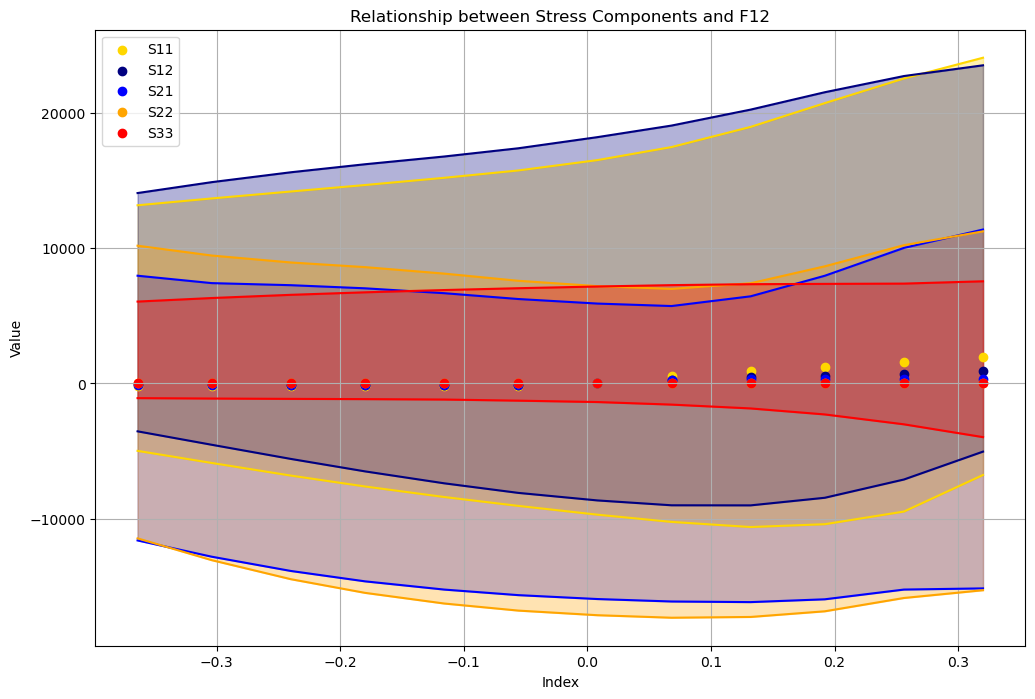

In [199]:
import matplotlib.pyplot as plt
import numpy as np

# Extract true data
S11_true = P_test3[:, 0, 0]
S12_true = P_test3[:, 0, 1]
S13_true = P_test3[:, 0, 2]
S21_true = P_test3[:, 1, 0]
S22_true = P_test3[:, 1, 1]
S23_true = P_test3[:, 1, 2]
S31_true = P_test3[:, 2, 0]
S32_true = P_test3[:, 2, 1]
S33_true = P_test3[:, 2, 2]

F12_true = F_test3[:, 0, 1]

result_test_dg_pred_8_11 = result_test_dg_pred_8[:, :, 0, 0]
max_stresses_11 = result_test_dg_pred_8_11.max(axis=0)
min_stresses_11 = result_test_dg_pred_8_11.min(axis=0)

result_test_dg_pred_8_12 = result_test_dg_pred_8[:, :, 0, 1]
max_stresses_12 = result_test_dg_pred_8_12.max(axis=0)  
min_stresses_12 = result_test_dg_pred_8_12.min(axis=0)  

result_test_dg_pred_8_13 = result_test_dg_pred_8[:, :, 0, 2]
max_stresses_13 = result_test_dg_pred_8_13.max(axis=0)
min_stresses_13 = result_test_dg_pred_8_13.min(axis=0)

result_test_dg_pred_8_21 = result_test_dg_pred_8[:, :, 1, 0]
max_stresses_21 = result_test_dg_pred_8_21.max(axis=0)
min_stresses_21 = result_test_dg_pred_8_21.min(axis=0)

result_test_dg_pred_8_22 = result_test_dg_pred_8[:, :, 1, 1]
max_stresses_22 = result_test_dg_pred_8_22.max(axis=0)
min_stresses_22 = result_test_dg_pred_8_22.min(axis=0)

result_test_dg_pred_8_23 = result_test_dg_pred_8[:, :, 1, 2]
max_stresses_23 = result_test_dg_pred_8_23.max(axis=0)
min_stresses_23 = result_test_dg_pred_8_23.min(axis=0)

result_test_dg_pred_8_31 = result_test_dg_pred_8[:, :, 2, 0]
max_stresses_31 = result_test_dg_pred_8_31.max(axis=0)
min_stresses_31 = result_test_dg_pred_8_31.min(axis=0)

result_test_dg_pred_8_32 = result_test_dg_pred_8[:, :, 2, 1]

max_stresses_32 = result_test_dg_pred_8_32.max(axis=0)
min_stresses_32 = result_test_dg_pred_8_32.min(axis=0)

result_test_dg_pred_8_33 = result_test_dg_pred_8[:, :, 2, 2]
max_stresses_33 = result_test_dg_pred_8_33.max(axis=0)
min_stresses_33 = result_test_dg_pred_8_33.min(axis=0)

# Generate x-axis values based on the length of the true data
num_points = 12
indices = np.linspace(0, len(F12_true) - 1, num_points, dtype=int)

x = F12_true[indices]
series = {
    "S11": (S11_true[indices], 'gold'),
    "S12": (S12_true[indices], 'navy'),
    "S21": (S21_true[indices], 'blue'),
    "S22": (S22_true[indices], 'orange'),

    "S33": (S33_true[indices], 'red'),
}

series2 = {
    "max_stresses_11": (max_stresses_11[indices] / b, 'gold'),
    "min_stresses_11": (min_stresses_11[indices] / b, 'gold'),
    "max_stresses_12": (max_stresses_12[indices] / b, 'navy'),
    "min_stresses_12": (min_stresses_12[indices] / b, 'navy'),
    "max_stresses_21": (max_stresses_21[indices] / b, 'blue'),
    "min_stresses_21": (min_stresses_21[indices] / b, 'blue'),
    "max_stresses_22": (max_stresses_22[indices] / b, 'orange'),
    "min_stresses_22": (min_stresses_22[indices] / b, 'orange'),

    "max_stresses_33": (max_stresses_33[indices] / b, 'red'),
    "min_stresses_33": (min_stresses_33[indices] / b, 'red'),
}

# Create the plot
plt.figure(figsize=(12, 8))

for label, (data, color) in series2.items():
    # 检查当前label是否为max或min的应力
    if "max" in label:  # 如果是最大值
        min_label = label.replace("max", "min")  # 找到对应的最小值
        min_data = series2[min_label][0]  # 获取对应的最小值数据
        
        # 填充最大值和最小值之间的区域
        plt.fill_between(x, min_data, data, color=color, alpha=0.3)
        
        # 绘制最大值和最小值曲线
        plt.plot(x, data, color=color)
        plt.plot(x, min_data, color=color)
# Plot each series
for label, (data, color) in series.items():
    plt.scatter(x, data, label=label, color=color)



# Customize the plot
plt.title('Relationship between Stress Components and F12')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


#### 16 observer

In [189]:
Cof_QF_16 = np.linalg.det(QF_16)[:, None, None] * np.linalg.inv(QF_16.transpose(0, 2, 1))
Cof_QF_16_input = Cof_QF_16.reshape(-1,9)
det_QF_16_input = np.linalg.det(QF_16)
QF_16_input = QF_16.reshape(-1,9)
QF_16_input_tensor = tf.convert_to_tensor(QF_16_input, dtype=tf.float32)
Cof_QF_16_tensor = tf.convert_to_tensor(Cof_QF_16_input, dtype=tf.float32)
det_QF_16_tensor = tf.convert_to_tensor(det_QF_16_input, dtype=tf.float32)


In [196]:
W_train_repeated_16 = np.tile(W_train, 16)
P_train_repeated_16 = np.tile(P_train, (16,1,1))
P_train_repeated_16_scaled, W_train_repeated_16_scaled, c = scale_data(P_train_repeated_16, W_train_repeated_16)
W_train_repeated_16_tensor = tf.convert_to_tensor(W_train_repeated_16_scaled, dtype=tf.float32)
P_train_repeated_16_tensor = tf.convert_to_tensor(P_train_repeated_16_scaled.reshape(-1,9), dtype=tf.float32)


In [191]:
models_ob16 = lm2_dg.main()

history = models_ob16.fit([QF_16_input_tensor,Cof_QF_16_tensor,det_QF_16_tensor], [W_train_repeated_16_tensor,P_train_repeated_16_tensor], epochs=2500)

Epoch 1/2500
138/138 [==============================] - 1s 1ms/step - loss: 1.2390 - f_to_w_and_p_14_loss: 1.2019 - f_to_w_and_p_14_1_loss: 0.0371
Epoch 2/2500
138/138 [==============================] - 0s 1ms/step - loss: 0.2976 - f_to_w_and_p_14_loss: 0.2621 - f_to_w_and_p_14_1_loss: 0.0355
Epoch 3/2500
138/138 [==============================] - 0s 1ms/step - loss: 0.1113 - f_to_w_and_p_14_loss: 0.0764 - f_to_w_and_p_14_1_loss: 0.0348
Epoch 4/2500
138/138 [==============================] - 0s 1ms/step - loss: 0.0579 - f_to_w_and_p_14_loss: 0.0234 - f_to_w_and_p_14_1_loss: 0.0345
Epoch 5/2500
138/138 [==============================] - 0s 1ms/step - loss: 0.0432 - f_to_w_and_p_14_loss: 0.0089 - f_to_w_and_p_14_1_loss: 0.0343
Epoch 6/2500
138/138 [==============================] - 0s 1ms/step - loss: 0.0397 - f_to_w_and_p_14_loss: 0.0056 - f_to_w_and_p_14_1_loss: 0.0342
Epoch 7/2500
138/138 [==============================] - 0s 1ms/step - loss: 0.0390 - f_to_w_and_p_14_loss: 0.0049 - f_

In [192]:
W_1024_test_dg_pred_16,P_1024_test_dg_pred_16= models_ob16([QF_1024_test_input_tensor,cof_QF_1024_test_tensor,det_QF_1024_test_tensor])

In [193]:
P_1024_test_dg_pred_16 = P_1024_test_dg_pred_16.numpy().reshape(1024,-1, 3, 3)
result_test_dg_pred_16 = np.einsum('nij,nmjk->nmik', Q_1024_T, P_1024_test_dg_pred_16)

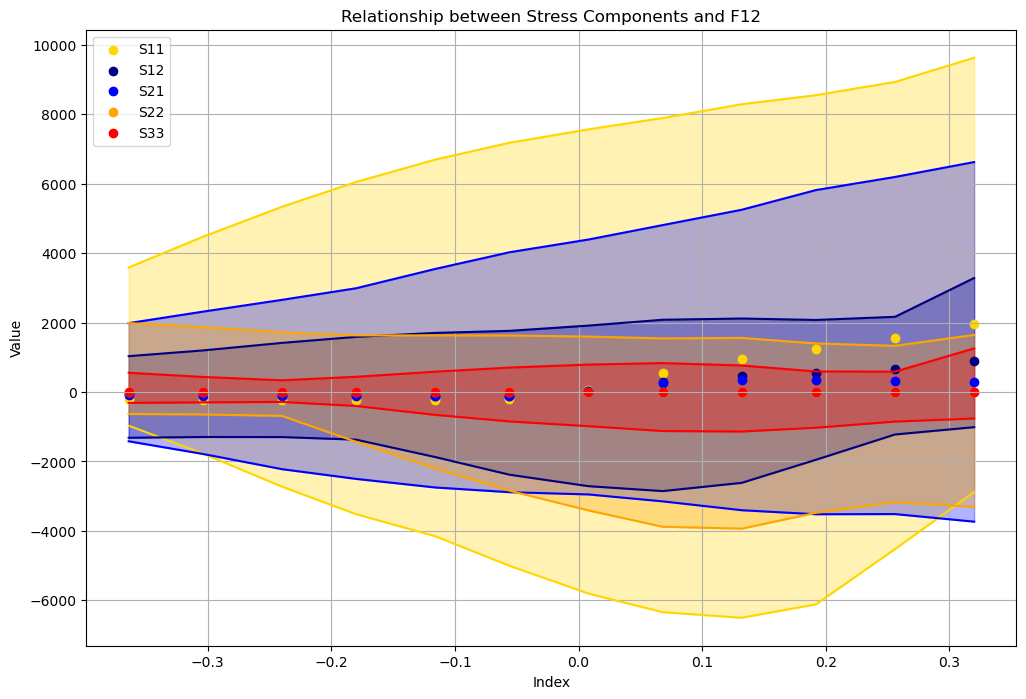

In [200]:
import matplotlib.pyplot as plt
import numpy as np

# Extract true data
S11_true = P_test3[:, 0, 0]
S12_true = P_test3[:, 0, 1]
S13_true = P_test3[:, 0, 2]
S21_true = P_test3[:, 1, 0]
S22_true = P_test3[:, 1, 1]
S23_true = P_test3[:, 1, 2]
S31_true = P_test3[:, 2, 0]
S32_true = P_test3[:, 2, 1]
S33_true = P_test3[:, 2, 2]

F12_true = F_test3[:, 0, 1]

result_test_dg_pred_16_11 = result_test_dg_pred_16[:, :, 0, 0]
max_stresses_11 = result_test_dg_pred_16_11.max(axis=0)
min_stresses_11 = result_test_dg_pred_16_11.min(axis=0)

result_test_dg_pred_16_12 = result_test_dg_pred_16[:, :, 0, 1]
max_stresses_12 = result_test_dg_pred_16_12.max(axis=0)  
min_stresses_12 = result_test_dg_pred_16_12.min(axis=0)  

result_test_dg_pred_16_13 = result_test_dg_pred_16[:, :, 0, 2]
max_stresses_13 = result_test_dg_pred_16_13.max(axis=0)
min_stresses_13 = result_test_dg_pred_16_13.min(axis=0)

result_test_dg_pred_16_21 = result_test_dg_pred_16[:, :, 1, 0]
max_stresses_21 = result_test_dg_pred_16_21.max(axis=0)
min_stresses_21 = result_test_dg_pred_16_21.min(axis=0)

result_test_dg_pred_16_22 = result_test_dg_pred_16[:, :, 1, 1]
max_stresses_22 = result_test_dg_pred_16_22.max(axis=0)
min_stresses_22 = result_test_dg_pred_16_22.min(axis=0)

result_test_dg_pred_16_23 = result_test_dg_pred_16[:, :, 1, 2]
max_stresses_23 = result_test_dg_pred_16_23.max(axis=0)
min_stresses_23 = result_test_dg_pred_16_23.min(axis=0)

result_test_dg_pred_16_31 = result_test_dg_pred_16[:, :, 2, 0]
max_stresses_31 = result_test_dg_pred_16_31.max(axis=0)
min_stresses_31 = result_test_dg_pred_16_31.min(axis=0)

result_test_dg_pred_16_32 = result_test_dg_pred_16[:, :, 2, 1]

max_stresses_32 = result_test_dg_pred_16_32.max(axis=0)
min_stresses_32 = result_test_dg_pred_16_32.min(axis=0)

result_test_dg_pred_16_33 = result_test_dg_pred_16[:, :, 2, 2]
max_stresses_33 = result_test_dg_pred_16_33.max(axis=0)
min_stresses_33 = result_test_dg_pred_16_33.min(axis=0)

# Generate x-axis values based on the length of the true data
num_points = 12
indices = np.linspace(0, len(F12_true) - 1, num_points, dtype=int)

x = F12_true[indices]
series = {
    "S11": (S11_true[indices], 'gold'),
    "S12": (S12_true[indices], 'navy'),
    "S21": (S21_true[indices], 'blue'),
    "S22": (S22_true[indices], 'orange'),

    "S33": (S33_true[indices], 'red'),
}

series2 = {
    "max_stresses_11": (max_stresses_11[indices] / c, 'gold'),
    "min_stresses_11": (min_stresses_11[indices] / c, 'gold'),
    "max_stresses_12": (max_stresses_12[indices] / c, 'navy'),
    "min_stresses_12": (min_stresses_12[indices] / c, 'navy'),
    "max_stresses_21": (max_stresses_21[indices] / b, 'blue'),
    "min_stresses_21": (min_stresses_21[indices] / b, 'blue'),
    "max_stresses_22": (max_stresses_22[indices] / c, 'orange'),
    "min_stresses_22": (min_stresses_22[indices] / c, 'orange'),

    "max_stresses_33": (max_stresses_33[indices] / c, 'red'),
    "min_stresses_33": (min_stresses_33[indices] / c, 'red'),
}

# Create the plot
plt.figure(figsize=(12, 8))

for label, (data, color) in series2.items():
    # 检查当前label是否为max或min的应力
    if "max" in label:  # 如果是最大值
        min_label = label.replace("max", "min")  # 找到对应的最小值
        min_data = series2[min_label][0]  # 获取对应的最小值数据
        
        # 填充最大值和最小值之间的区域
        plt.fill_between(x, min_data, data, color=color, alpha=0.3)
        
        # 绘制最大值和最小值曲线
        plt.plot(x, data, color=color)
        plt.plot(x, min_data, color=color)
# Plot each series
for label, (data, color) in series.items():
    plt.scatter(x, data, label=label, color=color)



# Customize the plot
plt.title('Relationship between Stress Components and F12')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


#### observer 32

In [202]:
Cof_QF_32 = np.linalg.det(QF_32)[:, None, None] * np.linalg.inv(QF_32.transpose(0, 2, 1))
Cof_QF_32_input = Cof_QF_32.reshape(-1,9)
det_QF_32_input = np.linalg.det(QF_32)
QF_32_input = QF_32.reshape(-1,9)
QF_32_input_tensor = tf.convert_to_tensor(QF_32_input, dtype=tf.float32)
Cof_QF_32_tensor = tf.convert_to_tensor(Cof_QF_32_input, dtype=tf.float32)
det_QF_32_tensor = tf.convert_to_tensor(det_QF_32_input, dtype=tf.float32)
W_train_repeated_32 = np.tile(W_train, 32)
P_train_repeated_32 = np.tile(P_train, (32,1,1))
P_train_repeated_32_scaled, W_train_repeated_32_scaled, d = scale_data(P_train_repeated_32, W_train_repeated_32)
W_train_repeated_32_tensor = tf.convert_to_tensor(W_train_repeated_32_scaled, dtype=tf.float32)
P_train_repeated_32_tensor = tf.convert_to_tensor(P_train_repeated_32_scaled.reshape(-1,9), dtype=tf.float32)



In [203]:
models_ob32 = lm2_dg.main()

history = models_ob32.fit([QF_32_input_tensor,Cof_QF_32_tensor,det_QF_32_tensor], [W_train_repeated_32_tensor,P_train_repeated_32_tensor], epochs=2500)

Epoch 1/2500
276/276 [==============================] - 1s 1ms/step - loss: 2.9330 - f_to_w_and_p_15_loss: 2.9016 - f_to_w_and_p_15_1_loss: 0.0314
Epoch 2/2500
276/276 [==============================] - 0s 1ms/step - loss: 0.2561 - f_to_w_and_p_15_loss: 0.2237 - f_to_w_and_p_15_1_loss: 0.0324
Epoch 3/2500
276/276 [==============================] - 0s 1ms/step - loss: 0.0600 - f_to_w_and_p_15_loss: 0.0271 - f_to_w_and_p_15_1_loss: 0.0329
Epoch 4/2500
276/276 [==============================] - 0s 1ms/step - loss: 0.0398 - f_to_w_and_p_15_loss: 0.0068 - f_to_w_and_p_15_1_loss: 0.0331
Epoch 5/2500
276/276 [==============================] - 0s 1ms/step - loss: 0.0379 - f_to_w_and_p_15_loss: 0.0048 - f_to_w_and_p_15_1_loss: 0.0331
Epoch 6/2500
276/276 [==============================] - 0s 1ms/step - loss: 0.0378 - f_to_w_and_p_15_loss: 0.0047 - f_to_w_and_p_15_1_loss: 0.0331
Epoch 7/2500
276/276 [==============================] - 0s 1ms/step - loss: 0.0378 - f_to_w_and_p_15_loss: 0.0047 - f_

In [204]:
W_1024_test_dg_pred_32,P_1024_test_dg_pred_32= models_ob32([QF_1024_test_input_tensor,cof_QF_1024_test_tensor,det_QF_1024_test_tensor])
P_1024_test_dg_pred_32 = P_1024_test_dg_pred_32.numpy().reshape(1024,-1, 3, 3)
result_test_dg_pred_32 = np.einsum('nij,nmjk->nmik', Q_1024_T, P_1024_test_dg_pred_32)

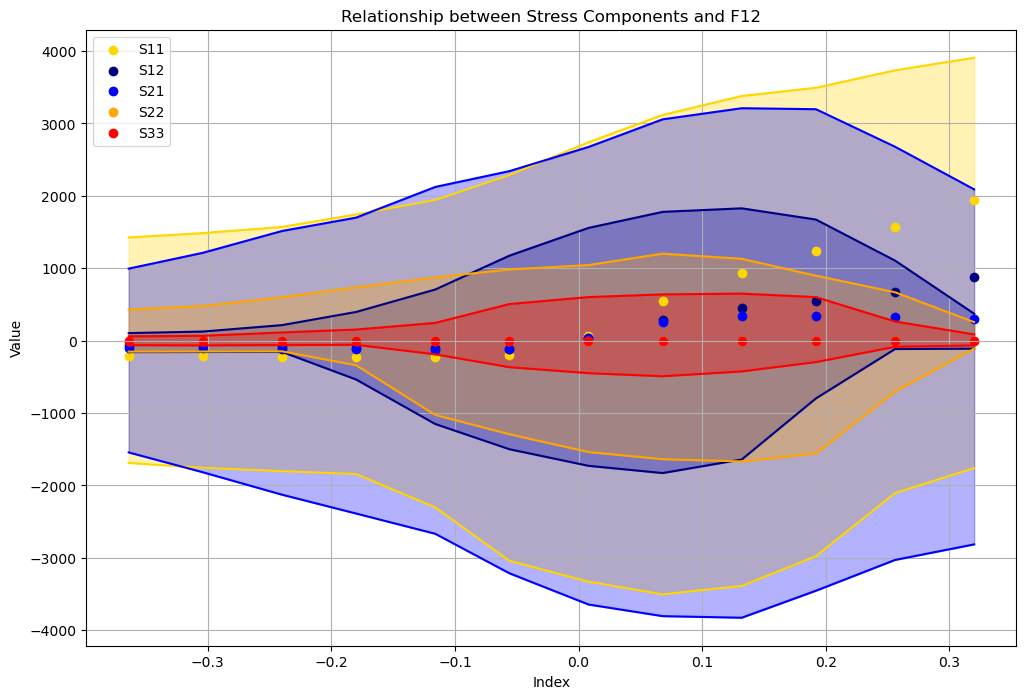

In [205]:
import matplotlib.pyplot as plt
import numpy as np

# Extract true data
S11_true = P_test3[:, 0, 0]
S12_true = P_test3[:, 0, 1]
S13_true = P_test3[:, 0, 2]
S21_true = P_test3[:, 1, 0]
S22_true = P_test3[:, 1, 1]
S23_true = P_test3[:, 1, 2]
S31_true = P_test3[:, 2, 0]
S32_true = P_test3[:, 2, 1]
S33_true = P_test3[:, 2, 2]

F12_true = F_test3[:, 0, 1]

result_test_dg_pred_32_11 = result_test_dg_pred_32[:, :, 0, 0]
max_stresses_11 = result_test_dg_pred_32_11.max(axis=0)
min_stresses_11 = result_test_dg_pred_32_11.min(axis=0)

result_test_dg_pred_32_12 = result_test_dg_pred_32[:, :, 0, 1]
max_stresses_12 = result_test_dg_pred_32_12.max(axis=0)  
min_stresses_12 = result_test_dg_pred_32_12.min(axis=0)  



result_test_dg_pred_32_21 = result_test_dg_pred_32[:, :, 1, 0]
max_stresses_21 = result_test_dg_pred_32_21.max(axis=0)
min_stresses_21 = result_test_dg_pred_32_21.min(axis=0)

result_test_dg_pred_32_22 = result_test_dg_pred_32[:, :, 1, 1]
max_stresses_22 = result_test_dg_pred_32_22.max(axis=0)
min_stresses_22 = result_test_dg_pred_32_22.min(axis=0)


result_test_dg_pred_32_33 = result_test_dg_pred_32[:, :, 2, 2]
max_stresses_33 = result_test_dg_pred_32_33.max(axis=0)
min_stresses_33 = result_test_dg_pred_32_33.min(axis=0)

# Generate x-axis values based on the length of the true data
num_points = 12
indices = np.linspace(0, len(F12_true) - 1, num_points, dtype=int)

x = F12_true[indices]
series = {
    "S11": (S11_true[indices], 'gold'),
    "S12": (S12_true[indices], 'navy'),
    "S21": (S21_true[indices], 'blue'),
    "S22": (S22_true[indices], 'orange'),

    "S33": (S33_true[indices], 'red'),
}

series2 = {
    "max_stresses_11": (max_stresses_11[indices] / d, 'gold'),
    "min_stresses_11": (min_stresses_11[indices] / d, 'gold'),
    "max_stresses_12": (max_stresses_12[indices] / d, 'navy'),
    "min_stresses_12": (min_stresses_12[indices] / d, 'navy'),
    "max_stresses_21": (max_stresses_21[indices] / d, 'blue'),
    "min_stresses_21": (min_stresses_21[indices] / d, 'blue'),
    "max_stresses_22": (max_stresses_22[indices] / d, 'orange'),
    "min_stresses_22": (min_stresses_22[indices] / d, 'orange'),

    "max_stresses_33": (max_stresses_33[indices] / d, 'red'),
    "min_stresses_33": (min_stresses_33[indices] / d, 'red'),
}

# Create the plot
plt.figure(figsize=(12, 8))

for label, (data, color) in series2.items():
    # 检查当前label是否为max或min的应力
    if "max" in label:  # 如果是最大值
        min_label = label.replace("max", "min")  # 找到对应的最小值
        min_data = series2[min_label][0]  # 获取对应的最小值数据
        
        # 填充最大值和最小值之间的区域
        plt.fill_between(x, min_data, data, color=color, alpha=0.3)
        
        # 绘制最大值和最小值曲线
        plt.plot(x, data, color=color)
        plt.plot(x, min_data, color=color)
# Plot each series
for label, (data, color) in series.items():
    plt.scatter(x, data, label=label, color=color)



# Customize the plot
plt.title('Relationship between Stress Components and F12')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


#### observer 64

In [206]:
Cof_QF_64 = np.linalg.det(QF_64)[:, None, None] * np.linalg.inv(QF_64.transpose(0, 2, 1))
Cof_QF_64_input = Cof_QF_64.reshape(-1,9)
det_QF_64_input = np.linalg.det(QF_64)
QF_64_input = QF_64.reshape(-1,9)
QF_64_input_tensor = tf.convert_to_tensor(QF_64_input, dtype=tf.float64)
Cof_QF_64_tensor = tf.convert_to_tensor(Cof_QF_64_input, dtype=tf.float64)
det_QF_64_tensor = tf.convert_to_tensor(det_QF_64_input, dtype=tf.float64)
W_train_repeated_64 = np.tile(W_train, 64)
P_train_repeated_64 = np.tile(P_train, (64,1,1))
P_train_repeated_64_scaled, W_train_repeated_64_scaled, e = scale_data(P_train_repeated_64, W_train_repeated_64)
W_train_repeated_64_tensor = tf.convert_to_tensor(W_train_repeated_64_scaled, dtype=tf.float64)
P_train_repeated_64_tensor = tf.convert_to_tensor(P_train_repeated_64_scaled.reshape(-1,9), dtype=tf.float64)



In [207]:
models_ob64 = lm2_dg.main()

history = models_ob64.fit([QF_64_input_tensor,Cof_QF_64_tensor,det_QF_64_tensor], [W_train_repeated_64_tensor,P_train_repeated_64_tensor], epochs=2500)

Epoch 1/2500
552/552 [==============================] - 1s 1ms/step - loss: 2.1442 - f_to_w_and_p_16_loss: 2.1110 - f_to_w_and_p_16_1_loss: 0.0333
Epoch 2/2500
552/552 [==============================] - 1s 1ms/step - loss: 0.0685 - f_to_w_and_p_16_loss: 0.0359 - f_to_w_and_p_16_1_loss: 0.0326
Epoch 3/2500
552/552 [==============================] - 1s 1ms/step - loss: 0.0377 - f_to_w_and_p_16_loss: 0.0050 - f_to_w_and_p_16_1_loss: 0.0327
Epoch 4/2500
552/552 [==============================] - 1s 1ms/step - loss: 0.0374 - f_to_w_and_p_16_loss: 0.0049 - f_to_w_and_p_16_1_loss: 0.0326
Epoch 5/2500
552/552 [==============================] - 1s 1ms/step - loss: 0.0373 - f_to_w_and_p_16_loss: 0.0049 - f_to_w_and_p_16_1_loss: 0.0324
Epoch 6/2500
552/552 [==============================] - 1s 1ms/step - loss: 0.0369 - f_to_w_and_p_16_loss: 0.0049 - f_to_w_and_p_16_1_loss: 0.0320
Epoch 7/2500
552/552 [==============================] - 1s 1ms/step - loss: 0.0361 - f_to_w_and_p_16_loss: 0.0052 - f_

In [208]:
W_1024_test_dg_pred_64,P_1024_test_dg_pred_64= models_ob64([QF_1024_test_input_tensor,cof_QF_1024_test_tensor,det_QF_1024_test_tensor])
P_1024_test_dg_pred_64 = P_1024_test_dg_pred_64.numpy().reshape(1024,-1, 3, 3)
result_test_dg_pred_64 = np.einsum('nij,nmjk->nmik', Q_1024_T, P_1024_test_dg_pred_64)

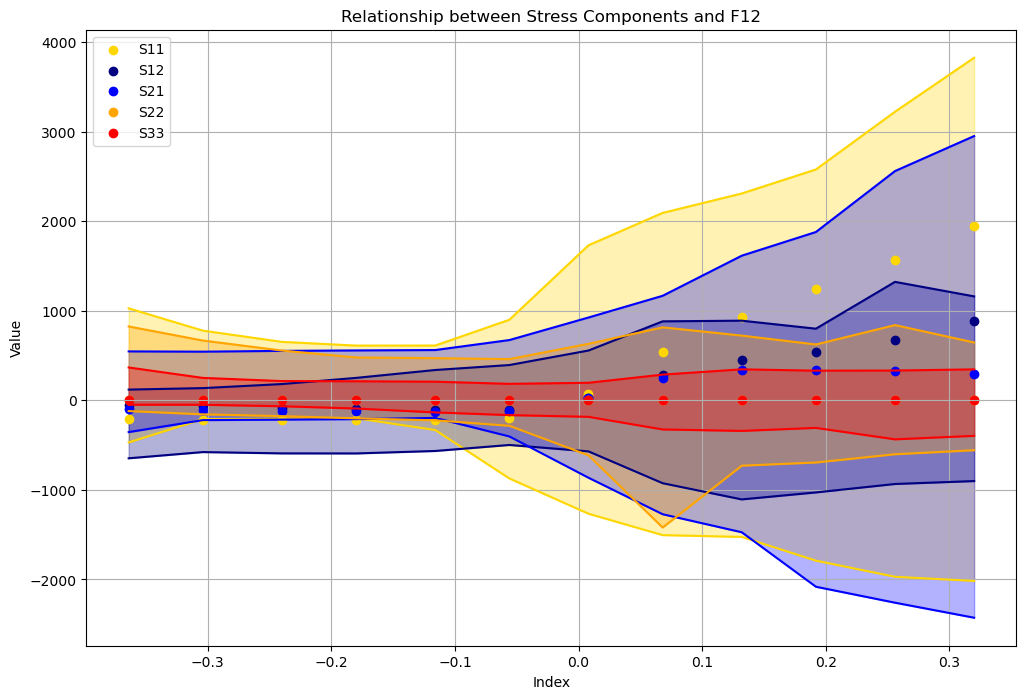

In [209]:
import matplotlib.pyplot as plt
import numpy as np

# Extract true data
S11_true = P_test3[:, 0, 0]
S12_true = P_test3[:, 0, 1]
S13_true = P_test3[:, 0, 2]
S21_true = P_test3[:, 1, 0]
S22_true = P_test3[:, 1, 1]
S23_true = P_test3[:, 1, 2]
S31_true = P_test3[:, 2, 0]
S32_true = P_test3[:, 2, 1]
S33_true = P_test3[:, 2, 2]

F12_true = F_test3[:, 0, 1]

result_test_dg_pred_64_11 = result_test_dg_pred_64[:, :, 0, 0]
max_stresses_11 = result_test_dg_pred_64_11.max(axis=0)
min_stresses_11 = result_test_dg_pred_64_11.min(axis=0)

result_test_dg_pred_64_12 = result_test_dg_pred_64[:, :, 0, 1]
max_stresses_12 = result_test_dg_pred_64_12.max(axis=0)  
min_stresses_12 = result_test_dg_pred_64_12.min(axis=0)  



result_test_dg_pred_64_21 = result_test_dg_pred_64[:, :, 1, 0]
max_stresses_21 = result_test_dg_pred_64_21.max(axis=0)
min_stresses_21 = result_test_dg_pred_64_21.min(axis=0)

result_test_dg_pred_64_22 = result_test_dg_pred_64[:, :, 1, 1]
max_stresses_22 = result_test_dg_pred_64_22.max(axis=0)
min_stresses_22 = result_test_dg_pred_64_22.min(axis=0)


result_test_dg_pred_64_33 = result_test_dg_pred_64[:, :, 2, 2]
max_stresses_33 = result_test_dg_pred_64_33.max(axis=0)
min_stresses_33 = result_test_dg_pred_64_33.min(axis=0)

# Generate x-axis values based on the length of the true data
num_points = 12
indices = np.linspace(0, len(F12_true) - 1, num_points, dtype=int)

x = F12_true[indices]
series = {
    "S11": (S11_true[indices], 'gold'),
    "S12": (S12_true[indices], 'navy'),
    "S21": (S21_true[indices], 'blue'),
    "S22": (S22_true[indices], 'orange'),

    "S33": (S33_true[indices], 'red'),
}

series2 = {
    "max_stresses_11": (max_stresses_11[indices] / d, 'gold'),
    "min_stresses_11": (min_stresses_11[indices] / d, 'gold'),
    "max_stresses_12": (max_stresses_12[indices] / d, 'navy'),
    "min_stresses_12": (min_stresses_12[indices] / d, 'navy'),
    "max_stresses_21": (max_stresses_21[indices] / d, 'blue'),
    "min_stresses_21": (min_stresses_21[indices] / d, 'blue'),
    "max_stresses_22": (max_stresses_22[indices] / d, 'orange'),
    "min_stresses_22": (min_stresses_22[indices] / d, 'orange'),

    "max_stresses_33": (max_stresses_33[indices] / d, 'red'),
    "min_stresses_33": (min_stresses_33[indices] / d, 'red'),
}

# Create the plot
plt.figure(figsize=(12, 8))

for label, (data, color) in series2.items():
    # 检查当前label是否为max或min的应力
    if "max" in label:  # 如果是最大值
        min_label = label.replace("max", "min")  # 找到对应的最小值
        min_data = series2[min_label][0]  # 获取对应的最小值数据
        
        # 填充最大值和最小值之间的区域
        plt.fill_between(x, min_data, data, color=color, alpha=0.3)
        
        # 绘制最大值和最小值曲线
        plt.plot(x, data, color=color)
        plt.plot(x, min_data, color=color)
# Plot each series
for label, (data, color) in series.items():
    plt.scatter(x, data, label=label, color=color)



# Customize the plot
plt.title('Relationship between Stress Components and F12')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()
